1. Upload `gasgain_output.tar.gz`
2. Run all

## setup

In [1]:
!tar -xzf gasgain_output.tar.gz
!mkdir plots

In [120]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import scipy.special as spi
from scipy.optimize import curve_fit

from google.colab import files
import csv

In [121]:
params = {
   'axes.labelsize': 21,
   'font.size': 16,
   'font.family': 'sans-serif',
   'font.serif': 'Arial',
   'legend.fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'axes.labelpad': 15,

   'figure.figsize': [10,8], # value in inches based on dpi of monitor
   'figure.dpi': 105.5, # My monitor has a dpi of around 105.5 px/inch

   'axes.grid': True,
   'grid.linestyle': '-',
   'grid.alpha': 0.25,
   'axes.linewidth': 1,
   'figure.constrained_layout.use': True,


   # Using Paul Tol's notes:
   'axes.prop_cycle':
      mpl.cycler(color=['#4477aa', # blue
                        '#ee6677', # red/pink
                        '#228833', # green
                        '#aa3377', # purple
                        '#66ccee', # cyan
                        '#ccbb44', # yellow
                        '#bbbbbb', # grey
                        ]),

      # Pick either the cycler above, or the cycler below:

      # (mpl.cycler(color=['#4477aa', # blue
      #                     '#ee6677', # red/pink
      #                     '#228833', # green
      #                     '#aa3377', # purple
      #                     '#66ccee', # cyan
      #                     '#ccbb44', # yellow
      #                     '#bbbbbb', # grey
      #                     ]) +
      #   mpl.cycler(linestyle=['-', # solid
      #                         '--', # dashed
      #                         ':', # dotted
      #                         '-.', # dash dot
      #                         (0, (3, 1, 1, 1, 1, 1)), # narrow dash dot dot
      #                         (0, (1, 2, 5, 2, 5, 2)), # dash dash dot
      #                         (0, (5, 2.5, 1, 2.5, 1, 2.5)), # dash dot dot
      #                         ])),

   'lines.linewidth': 2.5,

   'image.cmap': 'jet',
}


plt.rcParams.update(params)

In [122]:
def skgauss(n,m,a,alpha, mu):
  phi = np.exp(((((n/m)-mu))**2)/2)**-1
  phicdf = 2*(1+spi.erf(alpha*((n/m)-mu)))
  return a*phi*phicdf

## MIGDAL data

In [123]:
wA = 26.4
wC = 34.3
def charge_to_gain(charge, pA, pC):
    charge = np.array(charge)
    wval = 1/((1/wA - 1/wC)*(pA/(pA+3.01*pC)) + 1/wC)
    num_elec = charge*1E-12/1.6E-19
    prim_elec = 5.2E3/wval
    return (num_elec/prim_elec)

In [124]:
#Pure CF4 data
voltages_60Torr_cf4 = [610, 620, 600, 595, 580, 615, 590, 605]
pressures_60Torr_cf4 = np.ones(len(voltages_60Torr_cf4))*60
argon_per_60Torr_cf4 = np.zeros(len(voltages_60Torr_cf4))

ito_charge_60Torr_cf4 = [8.77, 13.54, 5.487, 4.260, 2.046, 10.921, 3.35, 6.939]
ito_charge_errs_60Torr_cf4 = [0.018, 0.034, 0.02, 0.019, 0.01, 0.025, 0.019, 0.015]
ito_res_60Torr_cf4 = [16.8, 16.2, 21.4, 25.5, 45.2, 16.5, 30, 18.3]
ito_res_errs_60Torr_cf4 = [0.2, 0.3, 0.4, 0.5, 0.5, 0.2, 0.6,  0.2]

#30% Ar data
voltages_60Torr_3070 = [540,550,555,560,565,570, 575, 580,585,590]
pressures_60Torr_3070 = np.ones(len(voltages_60Torr_3070))*60
argon_per_60Torr_3070 = np.ones(len(voltages_60Torr_3070))*30

ito_charge_60Torr_3070 = [1.364,2.173,2.795, 3.602,4.694,6.114,7.865, 10.035,12.737,16.079]
ito_charge_errs_60Torr_3070 = [0.009, 0.018, 0.023, 0.019, 0.007, 0.024, 0.018, 0.021, 0.024, 0.008]
ito_res_60Torr_3070 = [35.3, 15.2, 19.7, 17.2, 64.1, 24.5, 29.5, 15.8, 15, 42.7]
ito_res_errs_60Torr_3070 = [0.4, 0.2, 0.4, 0.3, 0.5, 0.5, 0.5, 0.2, 0.2, 0.4]

## Simulation data

In [125]:
voltages_sim_purecf4 = [590,600,610,615,620]
voltages_sim_3070 = [550,560,570,580,590]
gains_sim_purecf4 = [0,0,0,0,0]
err_sim_purecf4 = [0,0,0,0,0]
gains_sim_3070 = [0,0,0,0,0]
err_sim_3070 = [0,0,0,0,0]

### Pure CF4

#### 590V

1353 data points


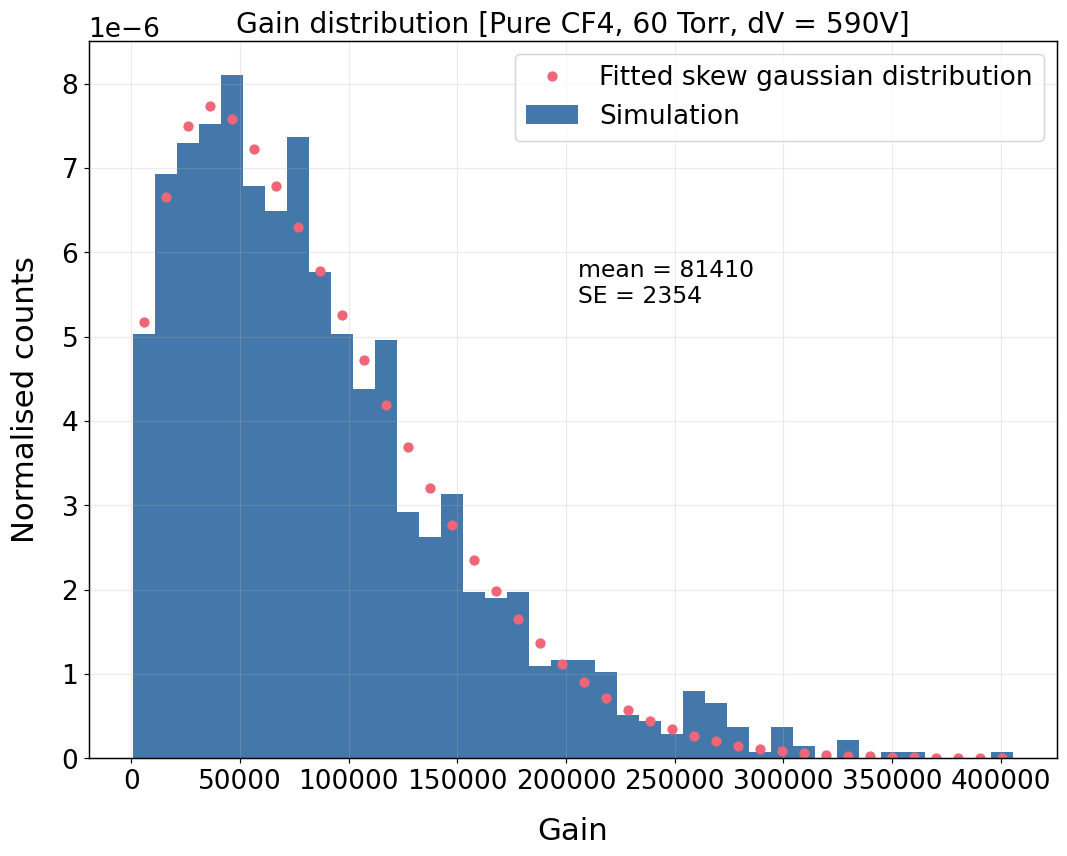

In [126]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output590_0/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 40

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [Pure CF4, 60 Torr, dV = 590V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[100000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-200000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_purecf4[0] = ex
err_sim_purecf4[0] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/590_0.png")

#### 600V

3584 data points


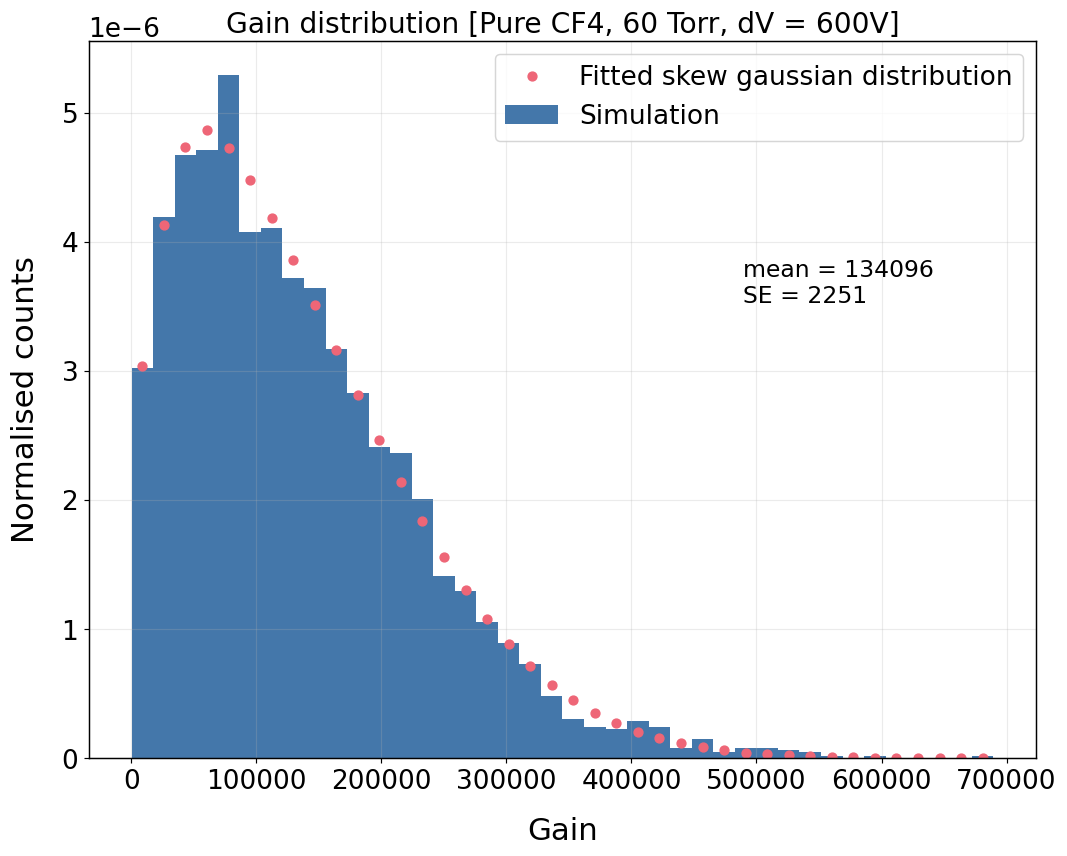

In [127]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output600_0/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 40

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [Pure CF4, 60 Torr, dV = 600V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[100000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-200000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_purecf4[1] = ex
err_sim_purecf4[1] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/600_0.png")

#### 610V

2257 data points


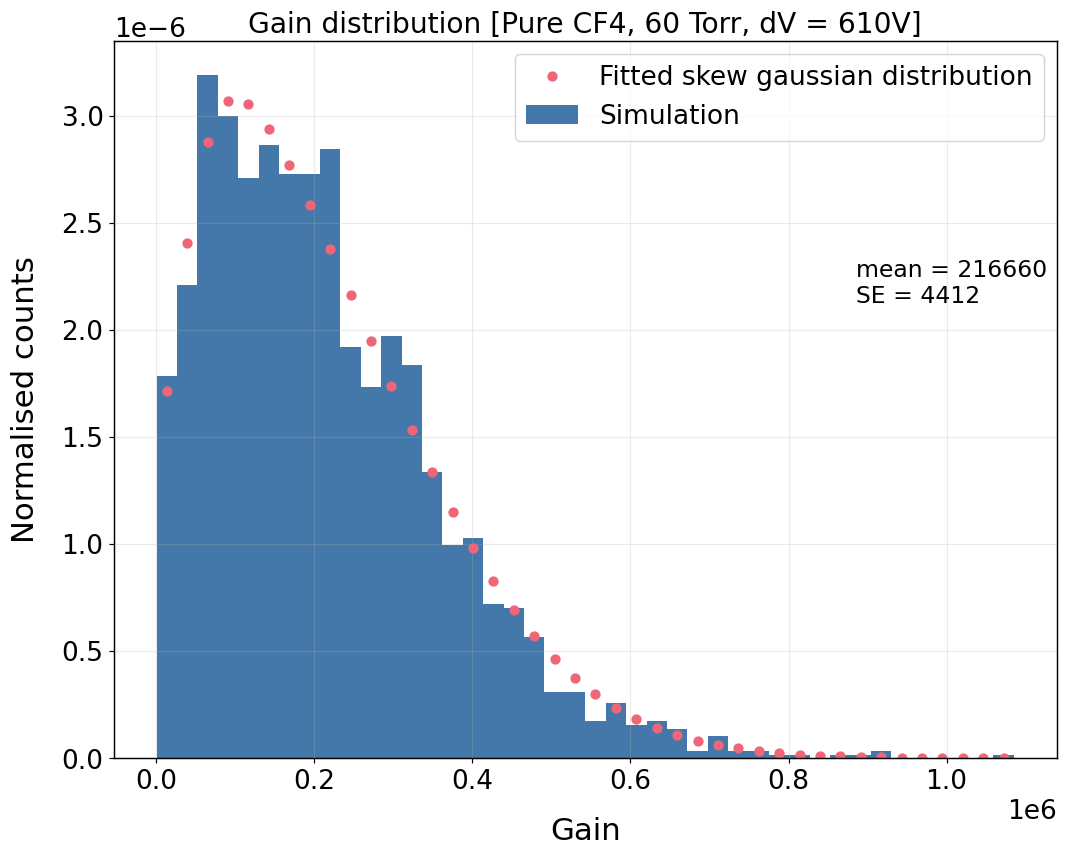

In [128]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output610_0/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 42

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [Pure CF4, 60 Torr, dV = 610V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[100000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-200000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_purecf4[2] = ex
err_sim_purecf4[2] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/610_0.png")

#### 615V

1589 data points


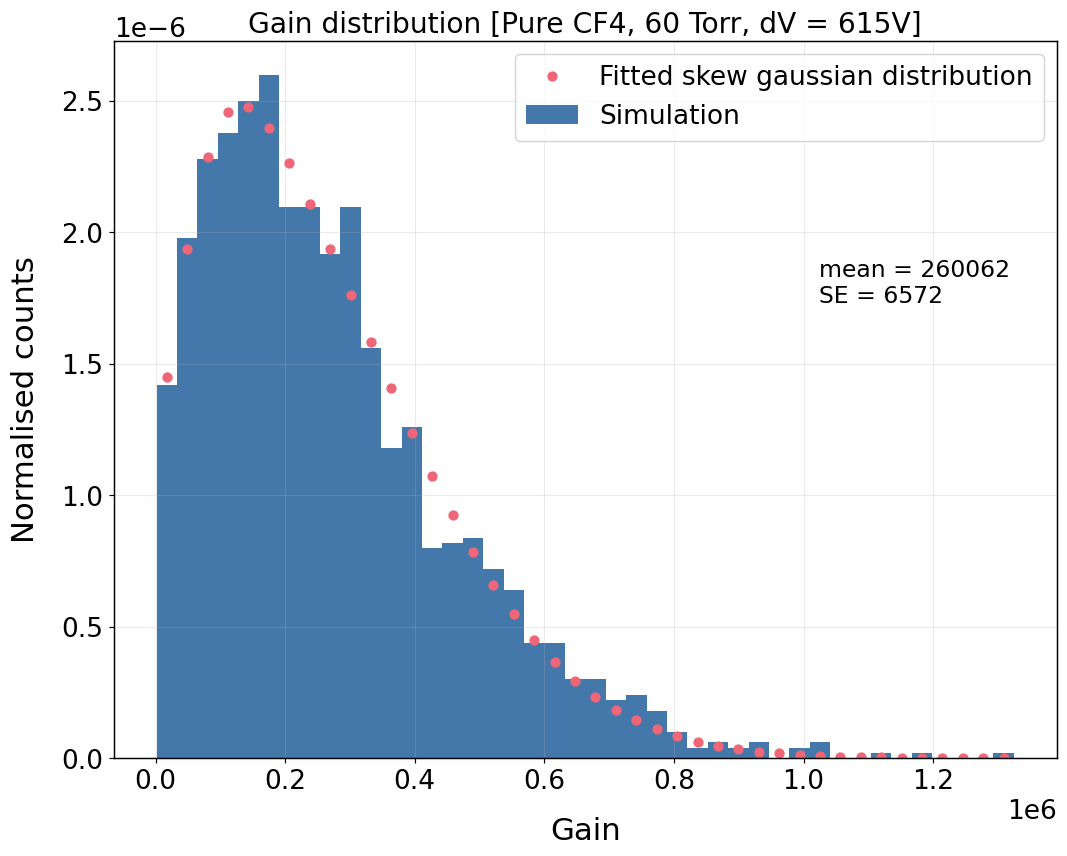

In [129]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output615_0/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 42

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [Pure CF4, 60 Torr, dV = 615V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[100000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-300000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_purecf4[3] = ex
err_sim_purecf4[3] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/615_0.png")

#### 620V

1654 data points


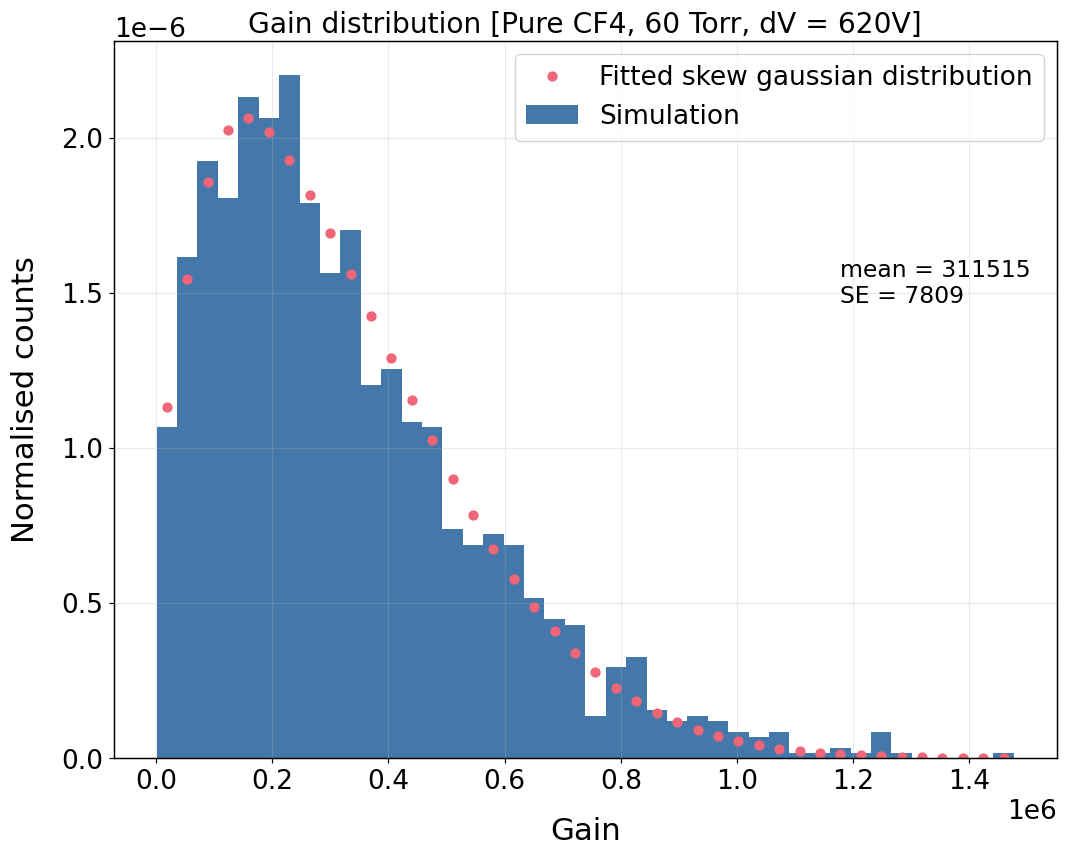

In [130]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output620_0/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 42

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [Pure CF4, 60 Torr, dV = 620V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[100000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-300000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_purecf4[4] = ex
err_sim_purecf4[4] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/620_0.png")

### 30% Ar

#### 550V

2151 data points


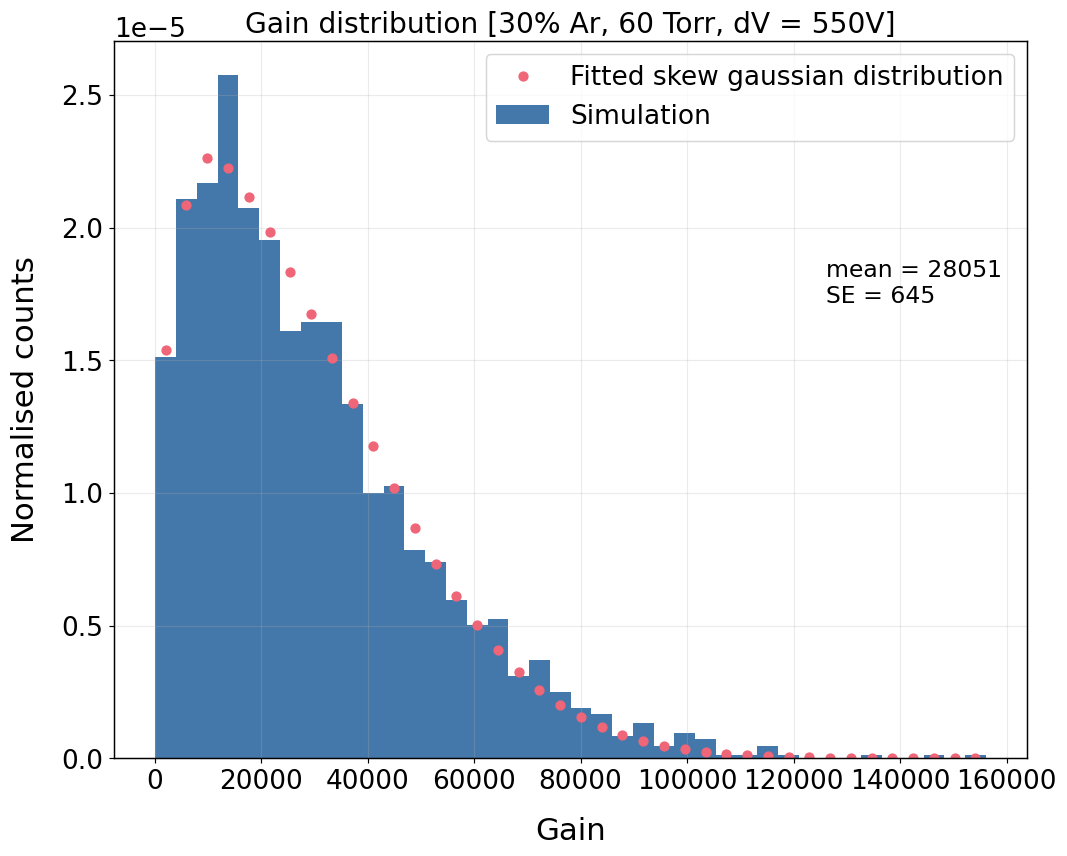

In [131]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output550_30/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 40

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [30% Ar, 60 Torr, dV = 550V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[50000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-30000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_3070[0] = ex
err_sim_3070[0] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/550_30.png")

#### 560V

2102 data points


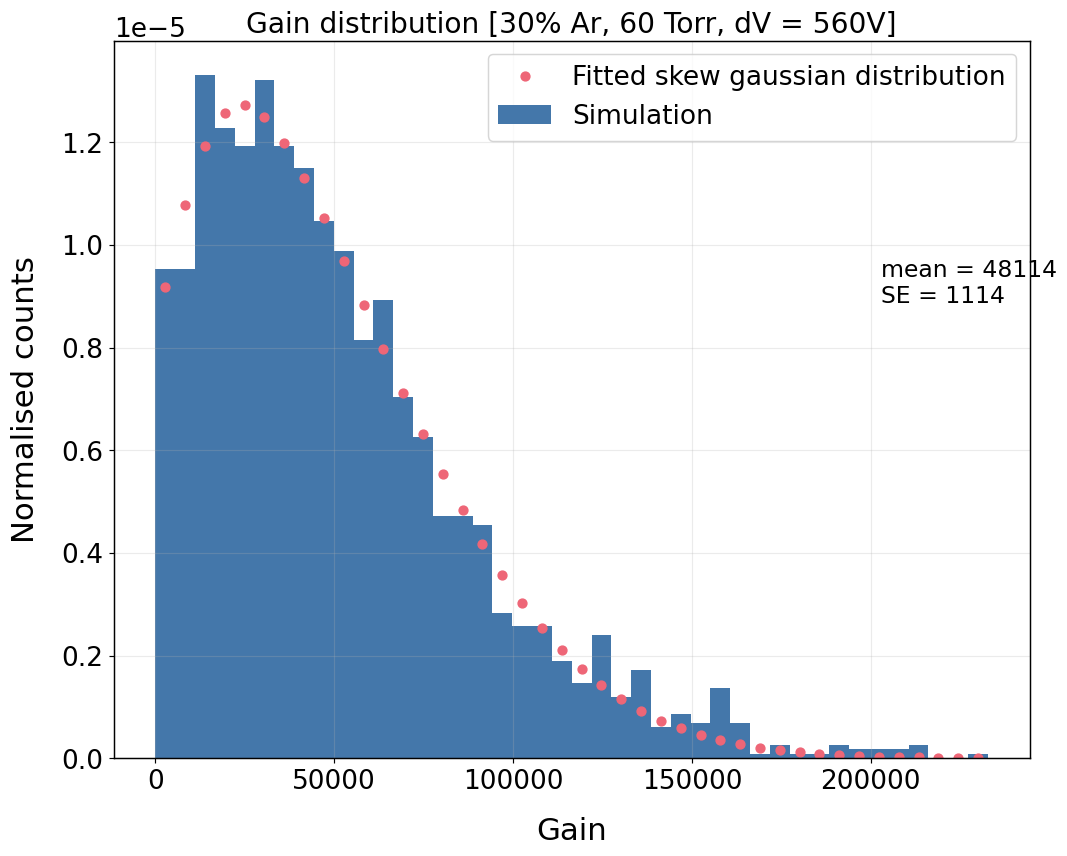

In [132]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output560_30/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 42

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [30% Ar, 60 Torr, dV = 560V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[50000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-30000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_3070[1] = ex
err_sim_3070[1] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/560_30.png")

#### 570V

2103 data points


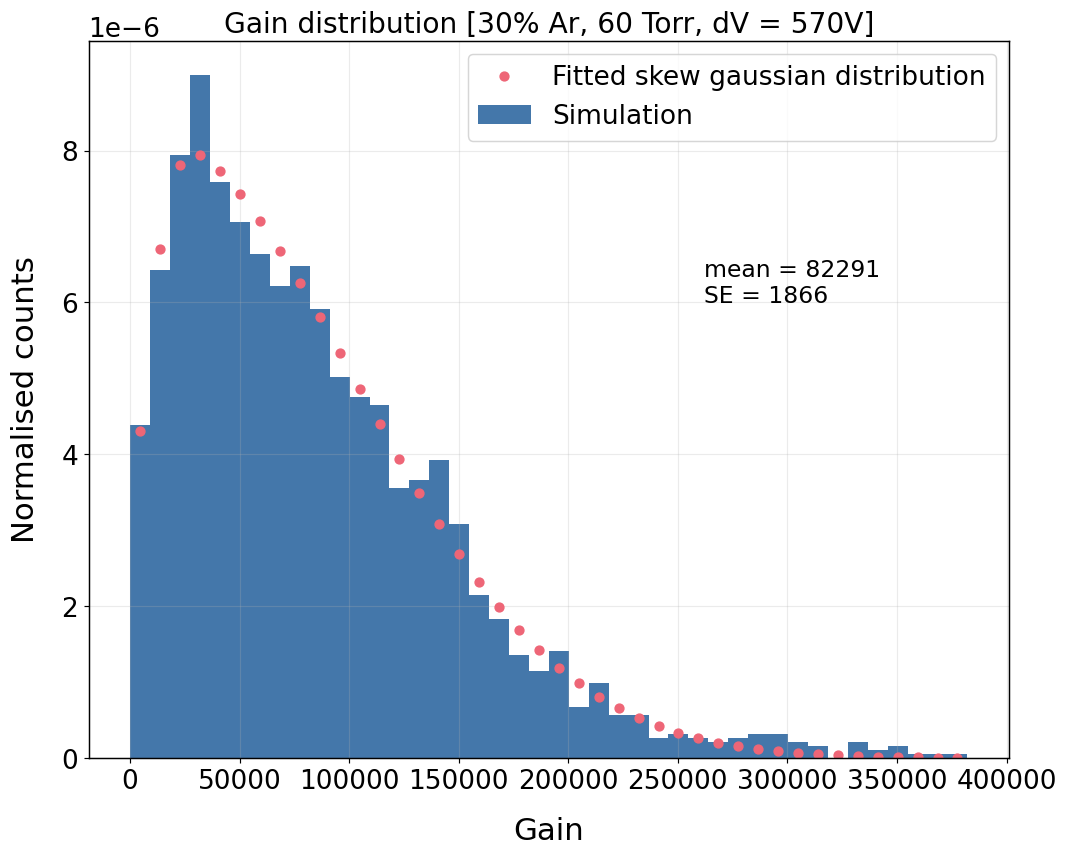

In [133]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output570_30/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 42

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [30% Ar, 60 Torr, dV = 570V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[50000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-120000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_3070[2] = ex
err_sim_3070[2] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/570_30.png")

#### 580V

1971 data points


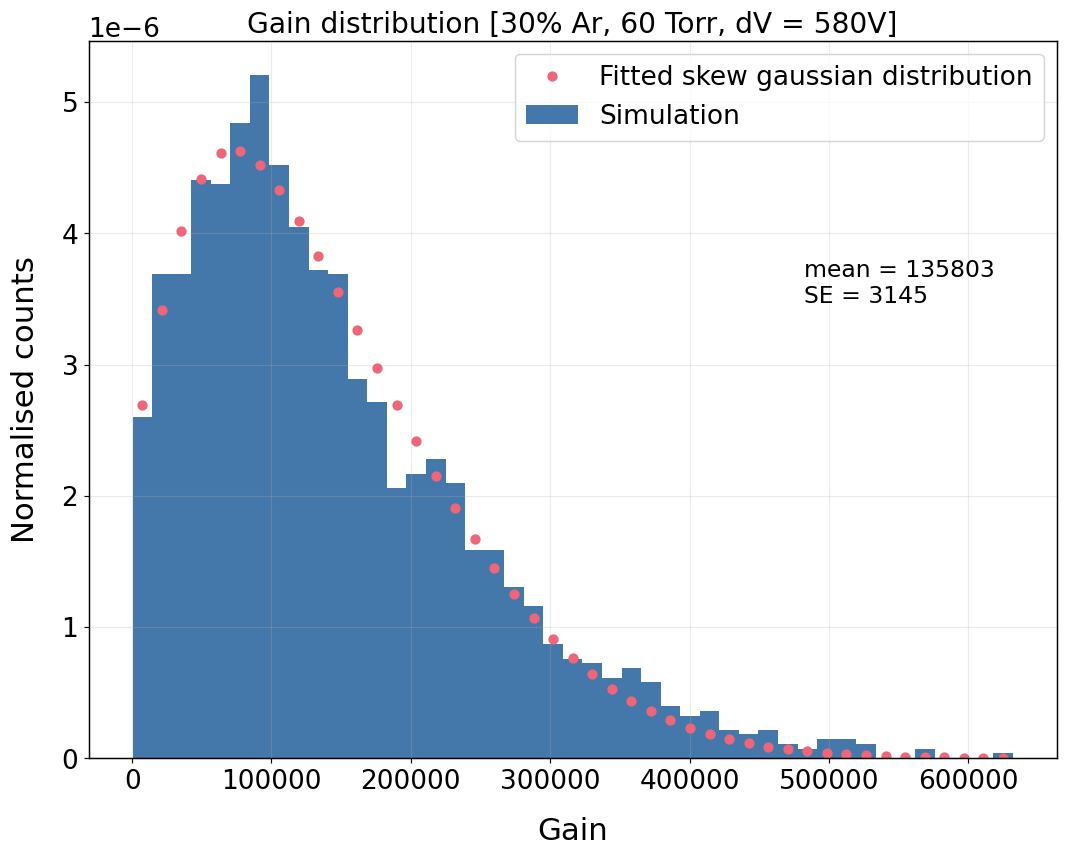

In [134]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output580_30/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 45

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [30% Ar, 60 Torr, dV = 580V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[50000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-150000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_3070[3] = ex
err_sim_3070[3] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/580_30.png")

#### 590V

1977 data points


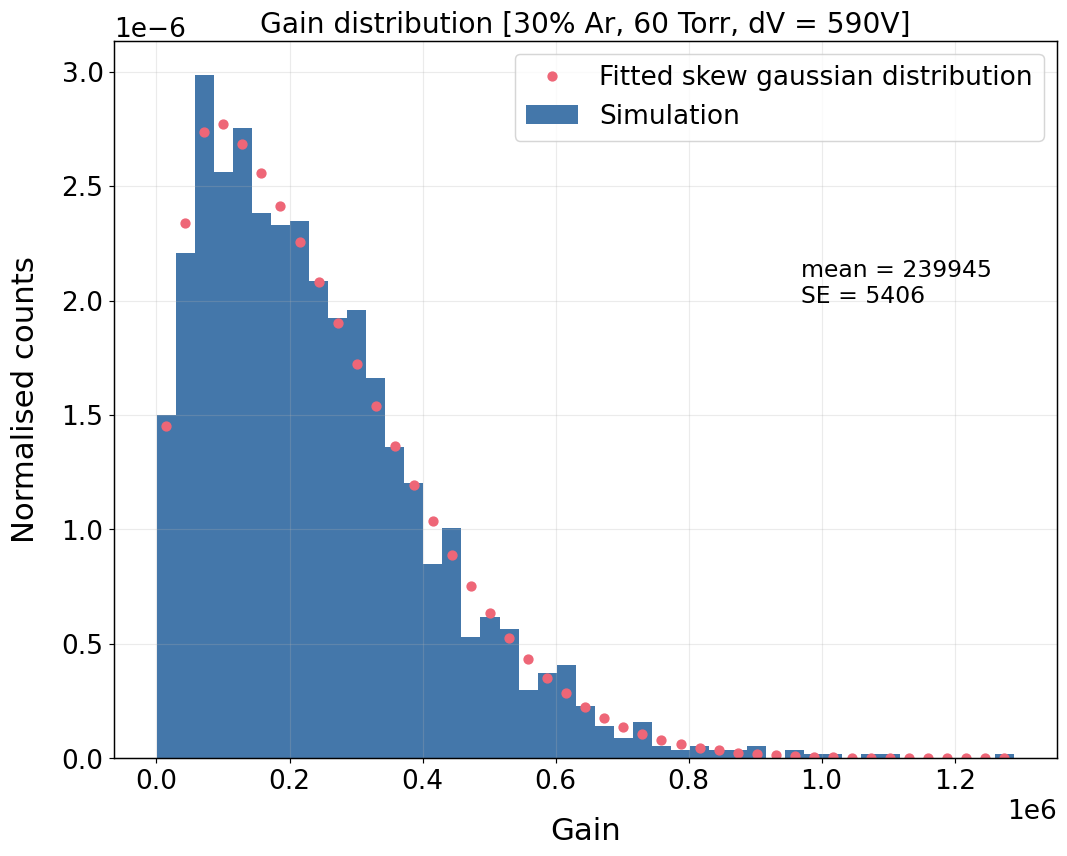

In [135]:
#importing data
num = 0
sizes = []
for i in range(1,5001,1):
  try:
    infile = open("output590_30/" + str(i) + ".csv","r")
  except FileNotFoundError:
    continue
  all = infile.readlines()
  lines = all[0]
  if int(lines)!=0:
    num+=1
    sizes.append(int(lines[:-1]))
print(str(num) + " data points")

#Plotting and fitting
n_bins = 45

#set up bins
bins = np.linspace(min(sizes),max(sizes), n_bins+1)
bin_width = (max(sizes)-min(sizes))/n_bins
bin_centres = []
for i in range(len(bins)-1):
  bin_centres.append((bins[1]-bins[0])*(i)+(bins[1]+bins[0])/2)

#Plot histogram
entries, bc, p = plt.hist(sizes, bins=bins, density=True, weights = np.ones_like(sizes)/num)
plt.xlabel("Gain")
plt.ylabel("Normalised counts")
plt.title("Gain distribution [30% Ar, 60 Torr, dV = 590V]")

#Fit, plot skew-Gaussian
parameters, cov_matrix = curve_fit(skgauss, bin_centres, entries, p0=[50000,0.000001,4,0.001])
y=[]
for i in bin_centres:
  y.append(skgauss(i,parameters[0],parameters[1],parameters[2],parameters[3]))
plt.plot(bin_centres,y,"o")
plt.legend(["Fitted skew gaussian distribution","Simulation"])

#Data mean, SD, SE
ex_d= 0
var_d = 0
for i in range(len(bin_centres)):
  ex_d += bin_centres[i]*entries[i]*bin_width
for i in range(len(bin_centres)):
  var_d += ((bin_centres[i]-ex_d)**2)*entries[i]*bin_width
sd_d = np.sqrt(var_d)
se_d = sd_d/np.sqrt(num)

#Fit mean, SD, SE
ex = 0
var = 0
for i in range(len(bin_centres)):
  ex += bin_centres[i]*y[i]*bin_width
for i in range(len(bin_centres)):
  var += ((bin_centres[i]-ex)**2)*y[i]*bin_width
sd = np.sqrt(var)
se = sd/np.sqrt(num)
plt.text(max(sizes)-320000,max(entries)/1.5,"mean = " + str(int(round(ex,0))) + "\nSE = " + str(int(round(np.sqrt((se**2)+(se_d**2)),0))))

gains_sim_3070[4] = ex
err_sim_3070[4] = np.sqrt((se**2)+(se_d**2))

plt.savefig("plots/590_30.png")

## Comparison

In [136]:
print(voltages_sim_purecf4)
print(gains_sim_purecf4)
print(err_sim_purecf4)
print("\n")
print(voltages_sim_3070)
print(gains_sim_3070)
print(err_sim_3070)

[590, 600, 610, 615, 620]
[81410.30315217433, 134095.62741291913, 216660.4845723599, 260062.19042448365, 311515.137086166]
[2354.185963293026, 2250.577196492055, 4412.162916215354, 6572.2850864417705, 7809.449574789309]


[550, 560, 570, 580, 590]
[28050.97485343709, 48113.90604231075, 82290.68349719654, 135802.51400824226, 239944.63921035497]
[645.180181562754, 1113.5719786430905, 1866.0317967017336, 3145.047883706743, 5405.580889800166]


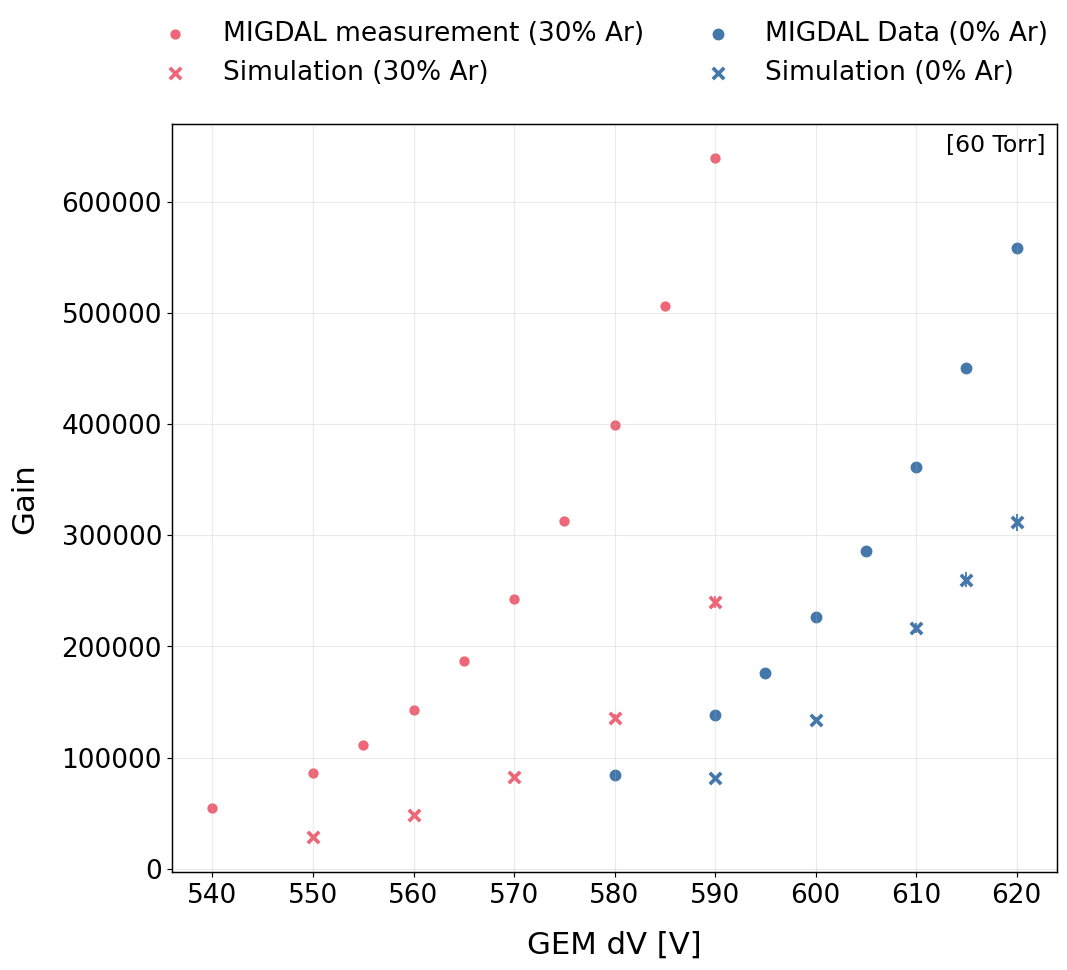

In [137]:
ax = plt.axes()

#Pure CF4
ax.scatter(voltages_60Torr_cf4,charge_to_gain(ito_charge_60Torr_cf4, 0, 60),label="MIGDAL Data (0% Ar)", s = 50.0)
ax.scatter(voltages_sim_purecf4,gains_sim_purecf4,label="Simulation (0% Ar)", marker='x', s=60.0,color='#4477aa')
ax.errorbar(voltages_sim_purecf4,gains_sim_purecf4,yerr=err_sim_purecf4,elinewidth = 1.2, ecolor = '#4477aa', ls='none')
ax.set_xlabel("GEM dV [V]")
ax.set_ylabel("Gain")

#30% Ar
ax.scatter(voltages_60Torr_3070,charge_to_gain(ito_charge_60Torr_3070, 18, 42),label="MIGDAL measurement (30% Ar)")
ax.scatter(voltages_sim_3070,gains_sim_3070,label="Simulation (30% Ar)", marker='x', s=60.0,color='#ee6677')
ax.errorbar(voltages_sim_3070,gains_sim_3070,yerr=err_sim_3070,elinewidth = 1.2, ecolor = '#ee6677', ls='none')


ax.text(613,645000,'[60 Torr]')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0.56,1.17),loc='upper right',mode='expand',ncols=2,frameon=False,fontsize=18)


plt.savefig("plots/comparison.png")


## Export

In [138]:
!tar -czf plots.tar.gz plots